ANALIZA PODATKOV O NEPREMIČNINAH NA TRGU

Najprej naložimo ustrezne knjižnice:

In [2]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt

pd.options.display.max_rows = 13
%matplotlib notebook

Naložimo podatke, ki jih bomo analizirali:

In [3]:
pot_oglasi = os.path.join('podatki_nepremicnine','nepremicnine.csv')
pot_regije = os.path.join('podatki_nepremicnine','regije.csv')
oglasi = pd.read_csv(pot_oglasi, index_col='id')
regije = pd.read_csv(pot_regije, index_col='indeks')

Za lažjo primerjavo cen stanovanj bomo najprej izračunali ceno vsakega stanovanja na kvadratni meter.

In [4]:
cene_na_m2 = oglasi.cena / oglasi.velikost
oglasi['cena_na_m2'] = cene_na_m2

Poglejmo si najprej, koliko stanovanj je naprodaj v posamezni regiji:

In [5]:
oglasi_z_regijami = pd.merge(oglasi, regije, left_on='regija', right_on='indeks', suffixes=('_indeks', '_ime'))
oglasi_z_regijami

,naslov,regija_indeks,velikost,zemljisce,tip,leto,obnova,opis,agencija,cena,cena_na_m2,regija_ime
0,AJDOVŠČINA,1,49.72,NaN,2.0,1925.0,2008.0,"49,72 m2, 2-sobno, zgrajeno l. 1925, adaptiran...",EURO NINE d.o.o.,95000.0,1910.699920,severna-primorska
1,AJDOVŠČINA,1,81.40,NaN,2.0,1997.0,NaN,"81,4 m2, 2-sobno, zgrajeno l. 1997, 1/2 nad., ...",EURO NINE d.o.o.,150000.0,1842.751843,severna-primorska
2,AJDOVŠČINA,1,81.40,NaN,2.0,1997.0,NaN,"81,4 m2, 2-sobno, zgrajeno l. 1997, prodamo. C...",Nepremičnine Land d.o.o.,150000.0,1842.751843,severna-primorska
3,AJDOVŠČINA,1,238.43,NaN,4.0,2018.0,NaN,"238,43 m2, 4-sobno, zgrajeno l. 2018, P/2 nad....","Aeon nepremičnine, d.o.o., PE Izola",178710.0,749.528163,severna-primorska
4,"AJDOVŠČINA, BEVKOVA ULICA 2",1,63.00,NaN,3.0,1978.0,2020.0,"63 m2, 3-sobno, zgrajeno l. 1978, adaptirano l...",Zasebna ponudba,130000.0,2063.492063,severna-primorska
...,...,...,...,...,...,...,...,...,...,...,...,...
2148,MURSKA SOBOTA,13,94.30,NaN,3.0,1980.0,2017.0,"94,3 m2, 3-sobno, dupleks, zgrajeno l. 1980, a...","APARTMA, nepremičnine, Nuša Vidic s.p.",129000.0,1367.974549,pomurska
2149,MURSKA SOBOTA,13,118.40,NaN,2.5,1928.0,NaN,"118,4 m2, 2,5-sobno, zgrajeno l. 1928, 1. nad....","Nepremičnine Pomurje, IMERS Igor Meolic s.p.",69800.0,589.527027,pomurska
2150,RADENCI,13,98.00,NaN,3.0,1974.0,2001.0,"98 m2, 3-sobno, zgrajeno l. 1974, adaptirano l...",Zasebna ponudba,120000.0,1224.489796,pomurska
2151,STARA CESTA,13,78.00,NaN,3.0,1950.0,NaN,"78 m2, 3-sobno, zgrajeno l. 1950, 1/2 nad., Pr...","Nepremičnine SV, Tomaž Poredoš s.p.",22000.0,282.051282,pomurska


<IPython.core.display.Javascript object>


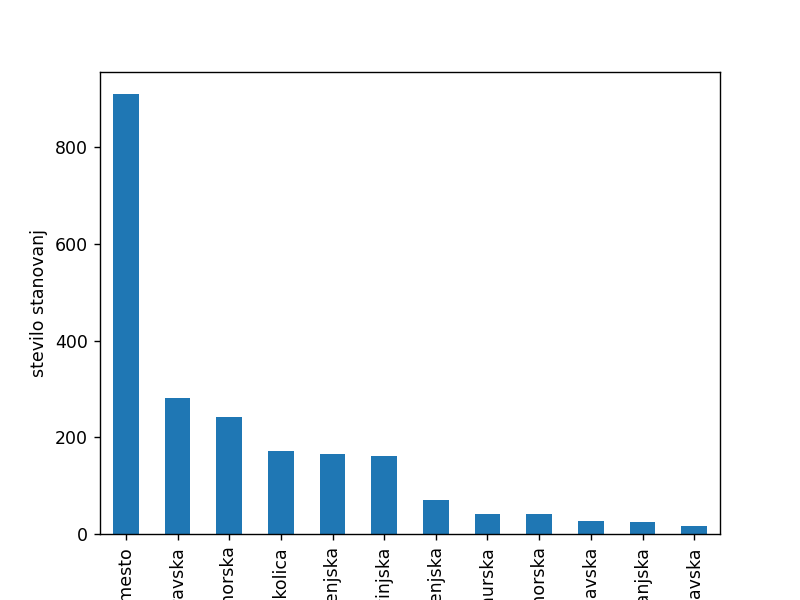

<AxesSubplot:xlabel='regija_ime', ylabel='stevilo stanovanj'>

In [52]:
oglasi_z_regijami.groupby('regija_ime').size().sort_values(ascending=False).plot.bar(xlabel='regija_ime', ylabel='stevilo stanovanj')

Primerjajmo še povprečne cene stanovanj na kvadratni meter med posameznimi regijami:

<IPython.core.display.Javascript object>


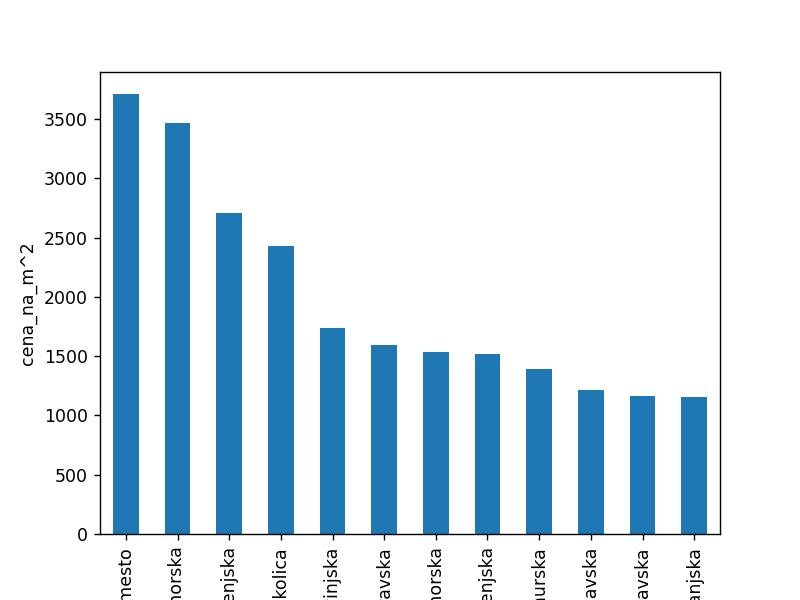

<AxesSubplot:xlabel='regija_ime', ylabel='cena_na_m^2'>

In [50]:
oglasi_z_regijami.groupby('regija_ime').mean().sort_values('cena_na_m2', ascending=False).cena_na_m2.plot.bar(xlabel='regija_ime', ylabel='cena_na_m^2')

Naša hipoteza je, da so manjša stanovanja dražja glede na kvadratni meter. To bomo preverili z naslednjim diagramom, ki prikazuje odvisnost med velikostjo stanovanja in njegovo ceno na kvadratni meter. Ker so nekateri nereprezentativni podatki uničevali kakovost diagrama, sem velikost omejila na 1500 m^2.

<IPython.core.display.Javascript object>


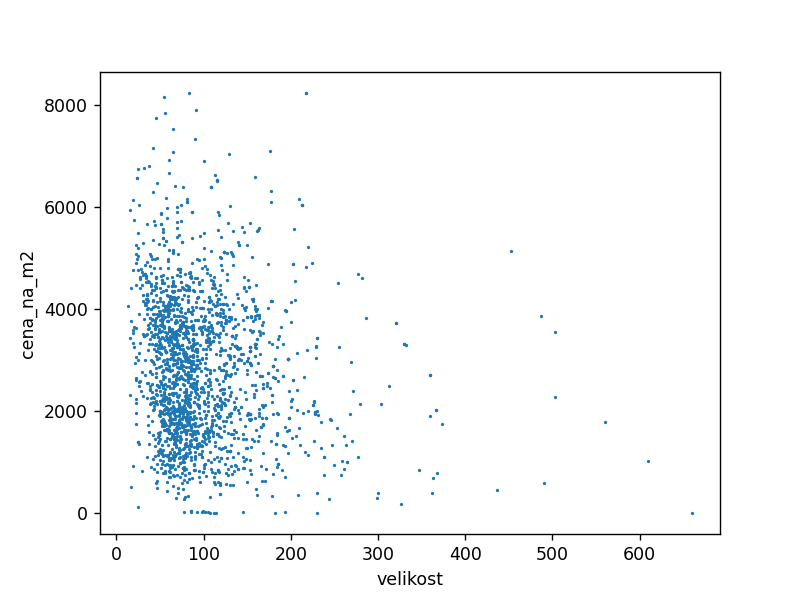

<AxesSubplot:xlabel='velikost', ylabel='cena_na_m2'>

In [84]:
oglasi[oglasi.velikost < 800].sort_values('velikost').plot.scatter(x='velikost', y='cena_na_m2', s=0.8)

Zanima nas tudi, ali cena na kvadratni meter pade pri večsobnih stanovanjih, oziroma ali so garsonjere res najdražje glede na kvadratni meter. To je razvidno iz naslednjega diagrama, ki pokaže da so v razmerju z velikostjo najdražja majhna stanovanja, najcenejša pa srednje velika stanovanja, ki jih je verjetno tudi največ na trgu.

<IPython.core.display.Javascript object>


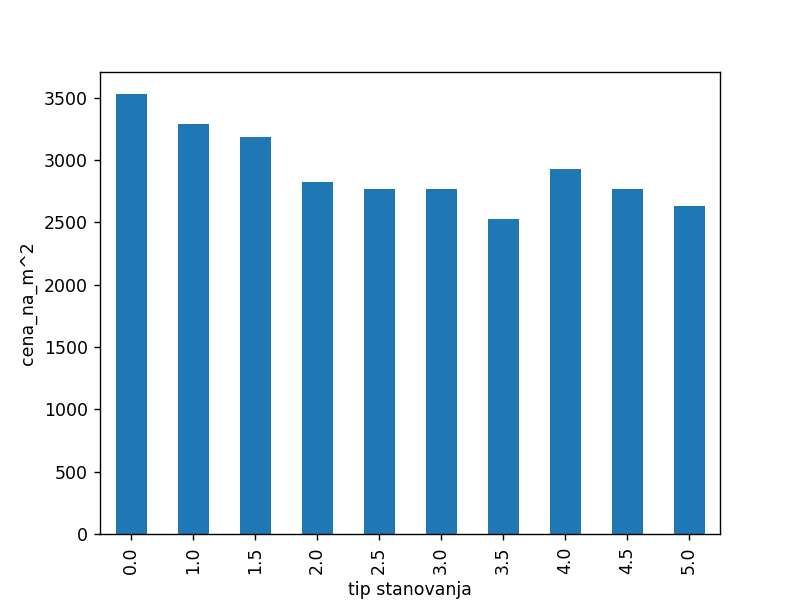

<AxesSubplot:xlabel='tip stanovanja', ylabel='cena_na_m^2'>

In [58]:
oglasi.groupby('tip').mean().cena_na_m2.plot.bar(xlabel='tip stanovanja', ylabel='cena_na_m^2')

Zanima nas tudi, ali leto izgradnje močno vpliva na ceno stanovanja. Za lažjo analizo bomo stanovanja razdelili na skupine po desetletjih in vzeli njihovo povprečje.

In [21]:
desetletje = oglasi.leto // 10 * 10
oglasi['desetletje'] = desetletje
oglasi

,naslov,regija,velikost,zemljisce,tip,leto,obnova,opis,agencija,cena,cena_na_m2,zadnja_dela,desetletje
id,,,,,,,,,,,,,
6435706,AJDOVŠČINA,1,49.72,NaN,2.0,1925.0,2008.0,"49,72 m2, 2-sobno, zgrajeno l. 1925, adaptiran...",EURO NINE d.o.o.,95000.0,1910.699920,2008.0,1920.0
6409286,AJDOVŠČINA,1,81.40,NaN,2.0,1997.0,0.0,"81,4 m2, 2-sobno, zgrajeno l. 1997, 1/2 nad., ...",EURO NINE d.o.o.,150000.0,1842.751843,1997.0,1990.0
6383103,AJDOVŠČINA,1,81.40,NaN,2.0,1997.0,0.0,"81,4 m2, 2-sobno, zgrajeno l. 1997, prodamo. C...",Nepremičnine Land d.o.o.,150000.0,1842.751843,1997.0,1990.0
6420905,AJDOVŠČINA,1,238.43,NaN,4.0,2018.0,0.0,"238,43 m2, 4-sobno, zgrajeno l. 2018, P/2 nad....","Aeon nepremičnine, d.o.o., PE Izola",178710.0,749.528163,2018.0,2010.0
6440399,"AJDOVŠČINA, BEVKOVA ULICA 2",1,63.00,NaN,3.0,1978.0,2020.0,"63 m2, 3-sobno, zgrajeno l. 1978, adaptirano l...",Zasebna ponudba,130000.0,2063.492063,2020.0,1970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6437775,MURSKA SOBOTA,13,94.30,NaN,3.0,1980.0,2017.0,"94,3 m2, 3-sobno, dupleks, zgrajeno l. 1980, a...","APARTMA, nepremičnine, Nuša Vidic s.p.",129000.0,1367.974549,2017.0,1980.0
6417432,MURSKA SOBOTA,13,118.40,NaN,2.5,1928.0,0.0,"118,4 m2, 2,5-sobno, zgrajeno l. 1928, 1. nad....","Nepremičnine Pomurje, IMERS Igor Meolic s.p.",69800.0,589.527027,1928.0,1920.0
6439789,RADENCI,13,98.00,NaN,3.0,1974.0,2001.0,"98 m2, 3-sobno, zgrajeno l. 1974, adaptirano l...",Zasebna ponudba,120000.0,1224.489796,2001.0,1970.0


Sedaj lahko stanovanja razdelimo na posamezne skupine in izračunamo povprečje:

<IPython.core.display.Javascript object>


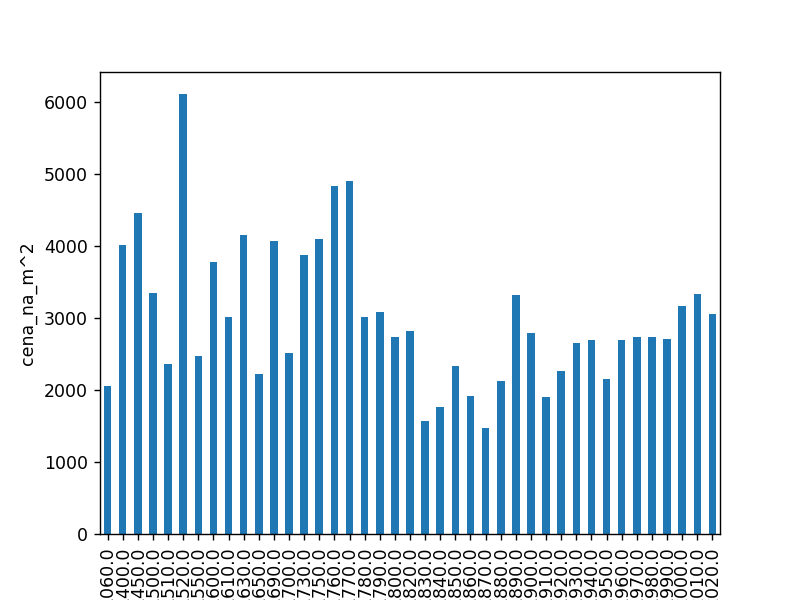

<AxesSubplot:xlabel='regija_ime', ylabel='cena_na_m^2'>

In [73]:
oglasi.groupby('desetletje').mean().cena_na_m2.plot.bar(xlabel='regija_ime', ylabel='cena_na_m^2')

Vidimo, da novejša stanovanja v povprečju niso dražja od starih, kar je presenetljivo. Zato preverimo še kdaj so bila stara stanovanja obnovljena. To bomo dosegli z ustrezno nastavljenimi vrednostmi za obnovo pri oglasih brez podatka o obnovi. S tem namenom bomo podatkom dodali stolpec, v katerem bo leto zadnjega dela na objektu. Če je bilo stanovanje obnovljeno, bo to torej leto obnove, sicer pa leto izgradnje.

In [22]:
oglasi['obnova'] = oglasi['obnova'].fillna(0)
zadnja_dela = oglasi[['leto', 'obnova']].max(axis=1)
oglasi['zadnja_dela'] = zadnja_dela
oglasi

,naslov,regija,velikost,zemljisce,tip,leto,obnova,opis,agencija,cena,cena_na_m2,zadnja_dela,desetletje
id,,,,,,,,,,,,,
6435706,AJDOVŠČINA,1,49.72,NaN,2.0,1925.0,2008.0,"49,72 m2, 2-sobno, zgrajeno l. 1925, adaptiran...",EURO NINE d.o.o.,95000.0,1910.699920,2008.0,1920.0
6409286,AJDOVŠČINA,1,81.40,NaN,2.0,1997.0,0.0,"81,4 m2, 2-sobno, zgrajeno l. 1997, 1/2 nad., ...",EURO NINE d.o.o.,150000.0,1842.751843,1997.0,1990.0
6383103,AJDOVŠČINA,1,81.40,NaN,2.0,1997.0,0.0,"81,4 m2, 2-sobno, zgrajeno l. 1997, prodamo. C...",Nepremičnine Land d.o.o.,150000.0,1842.751843,1997.0,1990.0
6420905,AJDOVŠČINA,1,238.43,NaN,4.0,2018.0,0.0,"238,43 m2, 4-sobno, zgrajeno l. 2018, P/2 nad....","Aeon nepremičnine, d.o.o., PE Izola",178710.0,749.528163,2018.0,2010.0
6440399,"AJDOVŠČINA, BEVKOVA ULICA 2",1,63.00,NaN,3.0,1978.0,2020.0,"63 m2, 3-sobno, zgrajeno l. 1978, adaptirano l...",Zasebna ponudba,130000.0,2063.492063,2020.0,1970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6437775,MURSKA SOBOTA,13,94.30,NaN,3.0,1980.0,2017.0,"94,3 m2, 3-sobno, dupleks, zgrajeno l. 1980, a...","APARTMA, nepremičnine, Nuša Vidic s.p.",129000.0,1367.974549,2017.0,1980.0
6417432,MURSKA SOBOTA,13,118.40,NaN,2.5,1928.0,0.0,"118,4 m2, 2,5-sobno, zgrajeno l. 1928, 1. nad....","Nepremičnine Pomurje, IMERS Igor Meolic s.p.",69800.0,589.527027,1928.0,1920.0
6439789,RADENCI,13,98.00,NaN,3.0,1974.0,2001.0,"98 m2, 3-sobno, zgrajeno l. 1974, adaptirano l...",Zasebna ponudba,120000.0,1224.489796,2001.0,1970.0


Zdaj lahko podobno analizo cene glede na desetletje izvedemo z novimi podatki o delih na stanovanju. Manjka nam le še stolpec z desetletjem zadnjega dela.

In [23]:
desetletje_dela = oglasi.zadnja_dela // 10 * 10
oglasi['desetletje_dela'] = desetletje_dela
oglasi

,naslov,regija,velikost,zemljisce,tip,leto,obnova,opis,agencija,cena,cena_na_m2,zadnja_dela,desetletje,desetletje_dela
id,,,,,,,,,,,,,,
6435706,AJDOVŠČINA,1,49.72,NaN,2.0,1925.0,2008.0,"49,72 m2, 2-sobno, zgrajeno l. 1925, adaptiran...",EURO NINE d.o.o.,95000.0,1910.699920,2008.0,1920.0,2000.0
6409286,AJDOVŠČINA,1,81.40,NaN,2.0,1997.0,0.0,"81,4 m2, 2-sobno, zgrajeno l. 1997, 1/2 nad., ...",EURO NINE d.o.o.,150000.0,1842.751843,1997.0,1990.0,1990.0
6383103,AJDOVŠČINA,1,81.40,NaN,2.0,1997.0,0.0,"81,4 m2, 2-sobno, zgrajeno l. 1997, prodamo. C...",Nepremičnine Land d.o.o.,150000.0,1842.751843,1997.0,1990.0,1990.0
6420905,AJDOVŠČINA,1,238.43,NaN,4.0,2018.0,0.0,"238,43 m2, 4-sobno, zgrajeno l. 2018, P/2 nad....","Aeon nepremičnine, d.o.o., PE Izola",178710.0,749.528163,2018.0,2010.0,2010.0
6440399,"AJDOVŠČINA, BEVKOVA ULICA 2",1,63.00,NaN,3.0,1978.0,2020.0,"63 m2, 3-sobno, zgrajeno l. 1978, adaptirano l...",Zasebna ponudba,130000.0,2063.492063,2020.0,1970.0,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6437775,MURSKA SOBOTA,13,94.30,NaN,3.0,1980.0,2017.0,"94,3 m2, 3-sobno, dupleks, zgrajeno l. 1980, a...","APARTMA, nepremičnine, Nuša Vidic s.p.",129000.0,1367.974549,2017.0,1980.0,2010.0
6417432,MURSKA SOBOTA,13,118.40,NaN,2.5,1928.0,0.0,"118,4 m2, 2,5-sobno, zgrajeno l. 1928, 1. nad....","Nepremičnine Pomurje, IMERS Igor Meolic s.p.",69800.0,589.527027,1928.0,1920.0,1920.0
6439789,RADENCI,13,98.00,NaN,3.0,1974.0,2001.0,"98 m2, 3-sobno, zgrajeno l. 1974, adaptirano l...",Zasebna ponudba,120000.0,1224.489796,2001.0,1970.0,2000.0


<IPython.core.display.Javascript object>


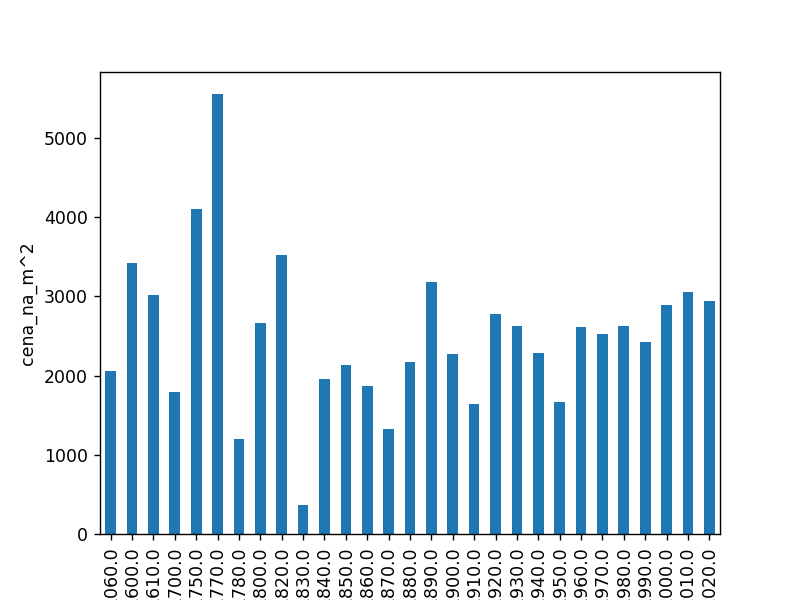

<AxesSubplot:xlabel='desetletje_dela', ylabel='cena_na_m^2'>

In [24]:
oglasi.groupby('desetletje_dela').mean().cena_na_m2.plot.bar(xlabel='desetletje_dela', ylabel='cena_na_m^2')

Iz zgornjega diagrama je razvidno, da naše hipoteze ne potrjuje. Vidimo, da so podatki za zelo stara stanovanja precej nekonstantni, kar je verjetno posledica pomanjkanja informacij o obnovi. Če pa se pri tej analizi osredotočimo le na stanovanja, ki so bila zgrajena oziroma obnovljena v 20. ali 21. stoletju.

<IPython.core.display.Javascript object>


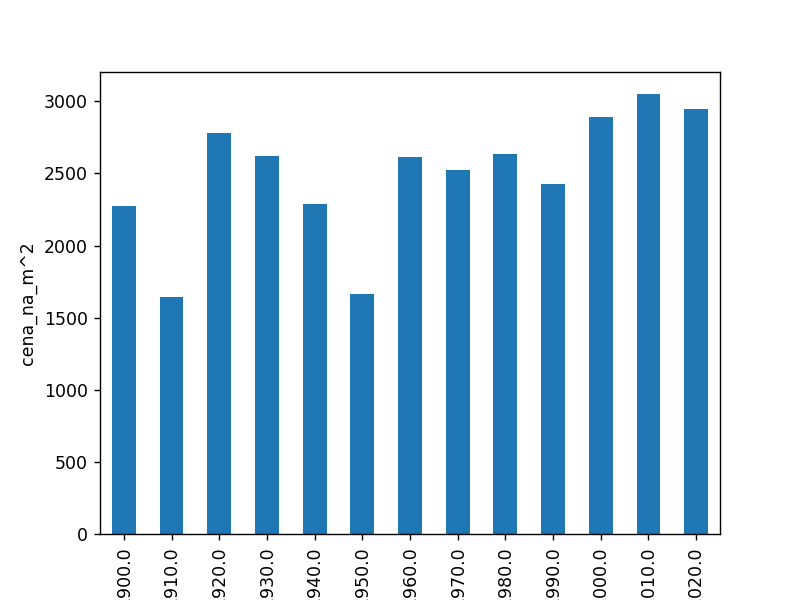

<AxesSubplot:xlabel='desetletje_dela', ylabel='cena_na_m^2'>

In [28]:
oglasi[oglasi.desetletje_dela >= 1900].groupby('desetletje_dela').mean().cena_na_m2.plot.bar(xlabel='desetletje_dela', ylabel='cena_na_m^2')

Vidimo, da so stanovanja iz zadnjih let res najdražja, vendar so razlike veliko manjše, kot bi pričakoval.

Za analiziranje vpliva posameznih lastnosti stanovanja na njegovo ceno na trgu bomo uporabili strojno učenje. Z uporabo knjižnice sklearn in nekaterih njenih modelov bomo dobili pomembnost posameznih spremenljivk pri napovedovanju cene stanovanja.